<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import glob, os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FILE NAME: 210902_#6_100_10_1um_i004.tif
DATE: 09/03/2021
PIXEL SIZE: 2.480469 nm
IMAGE SIZE: 2560x1920


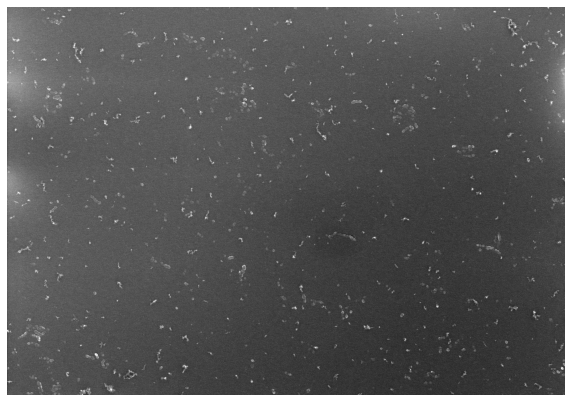

In [403]:
img = io.imread('/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.tif', as_gray=True)
img = np.array(img).astype(np.float32)

with open(f'/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.txt','r') as txt_file:
    txt = txt_file.read()
    del txt_file
    txt=txt.split('\n')
    txt=txt[1:-1]
    sem_dict = {}
    for row in txt:
        row = row.split('=')
        sem_dict.update({row[0]:  row[1]}) 
    print('FILE NAME:',sem_dict['ImageName'])
    print('DATE:',sem_dict['Date'] )    
    print('PIXEL SIZE:', sem_dict['PixelSize'],'nm')
    print('IMAGE SIZE:', sem_dict['DataSize'])
    pixelsize = float(sem_dict['PixelSize'])
    width, height = sem_dict['DataSize'].split('x')
    width, height = int(width), int(height)
    if height == 1920:
        img = img[0:1780,0:2560]
        height = 1780
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img,vmax=255, cmap='gray')
plt.show()

Max: 255.0
Min: 49.0
Median: 113.0
Average: 113.93178
IMAGE:


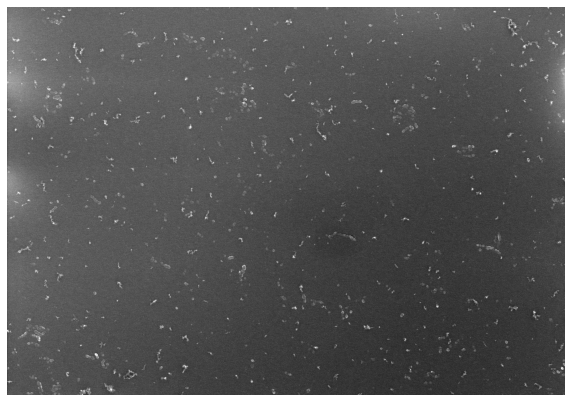

IMAGE HIST:


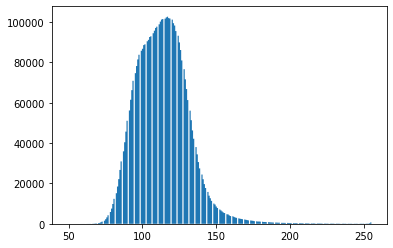

[145, 137, 132, 131, 131, 130, 129, 128, 128, 127, 127, 127, 127, 131, 132, 131, 128, 126, 126, 127, 149, 138, 132, 130, 131, 129, 129, 127, 126, 125, 124, 123, 123, 124, 124, 124, 123, 122, 123, 129, 150, 138, 132, 129, 128, 127, 127, 126, 125, 122, 121, 119, 119, 118, 118, 118, 118, 118, 120, 131, 161, 141, 134, 131, 128, 127, 126, 125, 124, 121, 119, 117, 117, 115, 114, 113, 113, 114, 118, 136, 156, 143, 132, 128, 127, 126, 125, 125, 124, 120, 118, 116, 115, 112, 112, 110, 110, 111, 115, 135, 139, 134, 127, 125, 124, 123, 123, 122, 122, 118, 116, 115, 112, 111, 111, 108, 108, 109, 113, 130, 129, 125, 124, 123, 123, 123, 123, 121, 119, 117, 114, 112, 110, 108, 108, 106, 106, 106, 109, 119, 127, 122, 122, 122, 121, 121, 121, 120, 118, 116, 113, 110, 108, 106, 105, 104, 106, 104, 107, 112, 140, 125, 123, 122, 122, 121, 121, 119, 117, 114, 111, 109, 106, 104, 103, 102, 101, 102, 105, 108, 149, 129, 123, 122, 121, 120, 120, 117, 114, 111, 107, 105, 102, 101, 100, 99, 99, 100, 102, 105, 1

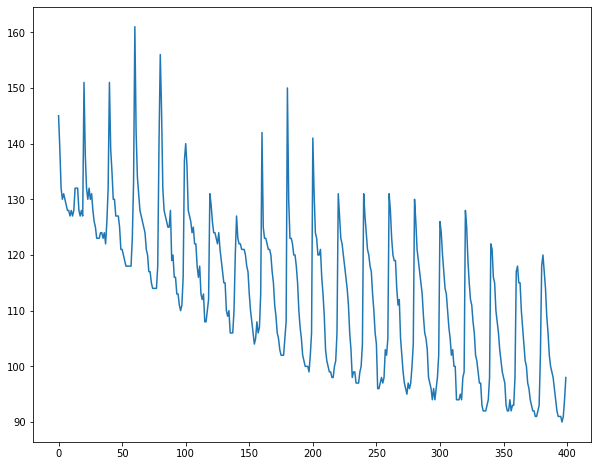

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


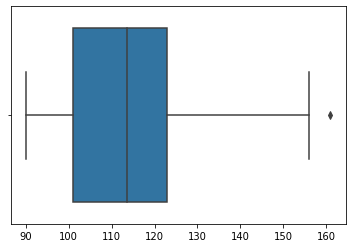

101.0
123.0
156.0
68.0
Median_HM


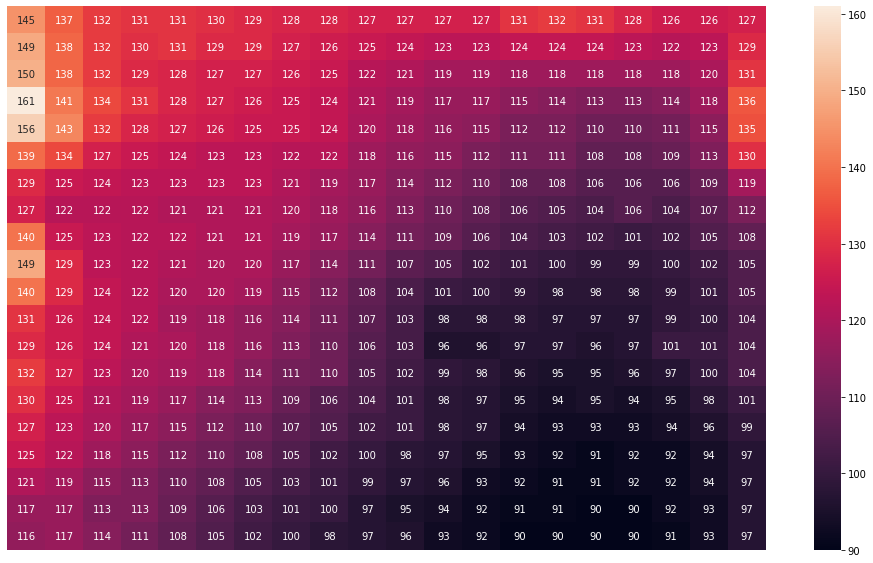

Average_HM


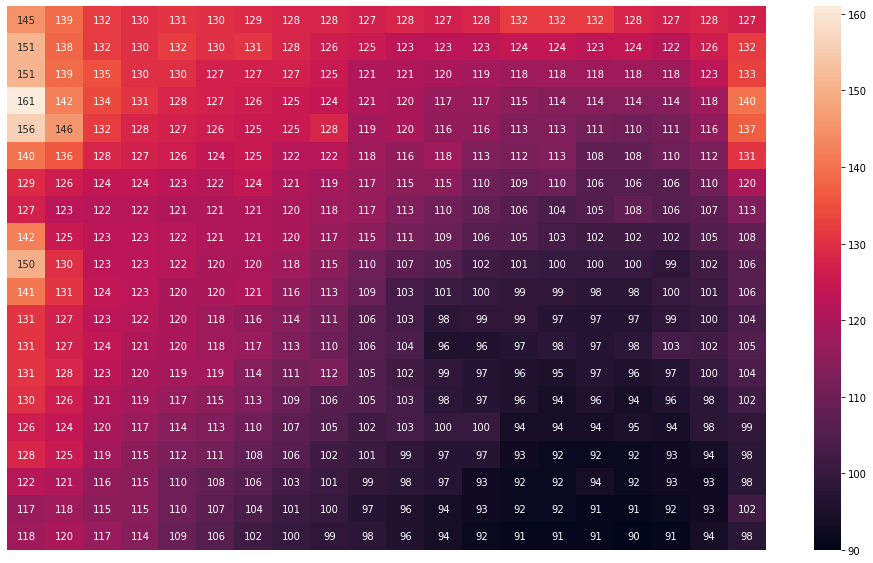

max/median_HM


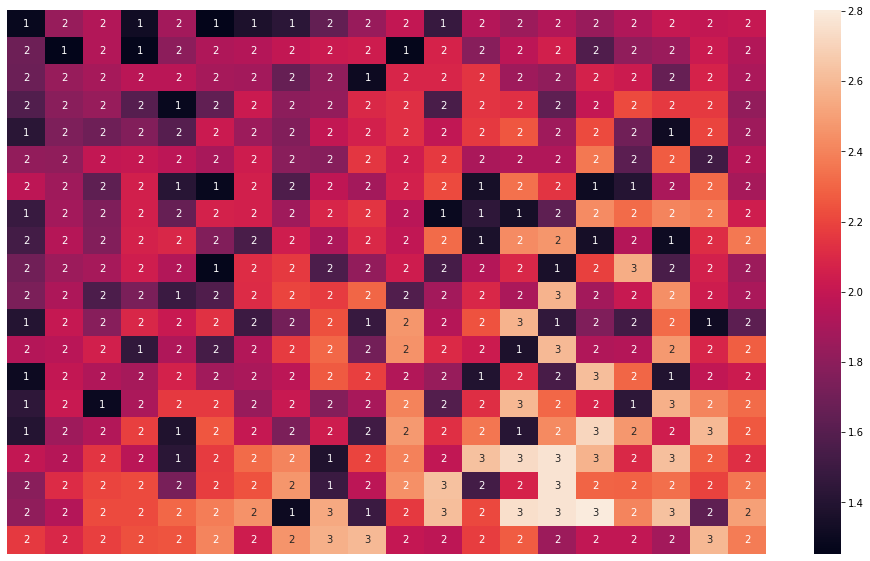

In [427]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print(median_img)
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    sns.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
image_info(img)

In [407]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    median_img2=[]
   
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.average(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
            
    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > np.median(median_img)*1.25 or np.median(img[x_min:x_max,y_min:y_max]) < np.median(median_img)*0.75 :
                print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 255
    img2[img2<0] = 0
    return img2, median_img, median_img2
img2, median_img,median_img2 = uniform(20,20)

Median Rectangle Box size: 89 x 128
Median intensity: 113.0
145.0
149.0
150.0
161.0
156.0
149.0


Max: 255.0
Min: 0.0
Median: 0.0
Average: 8.066351
IMAGE:


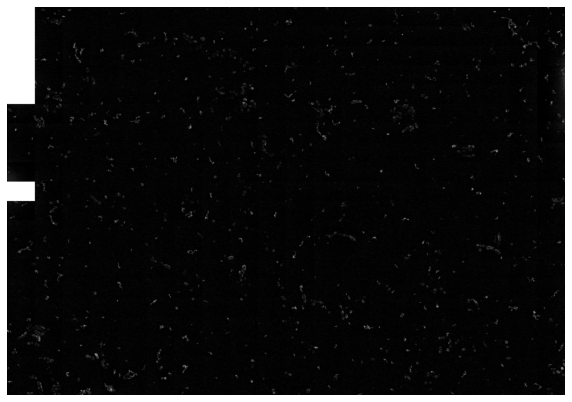

IMAGE HIST:


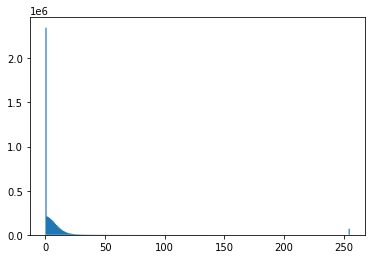

Average:


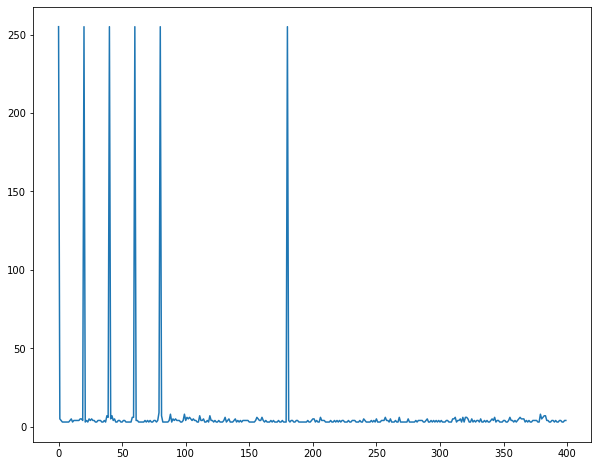

Median_HM


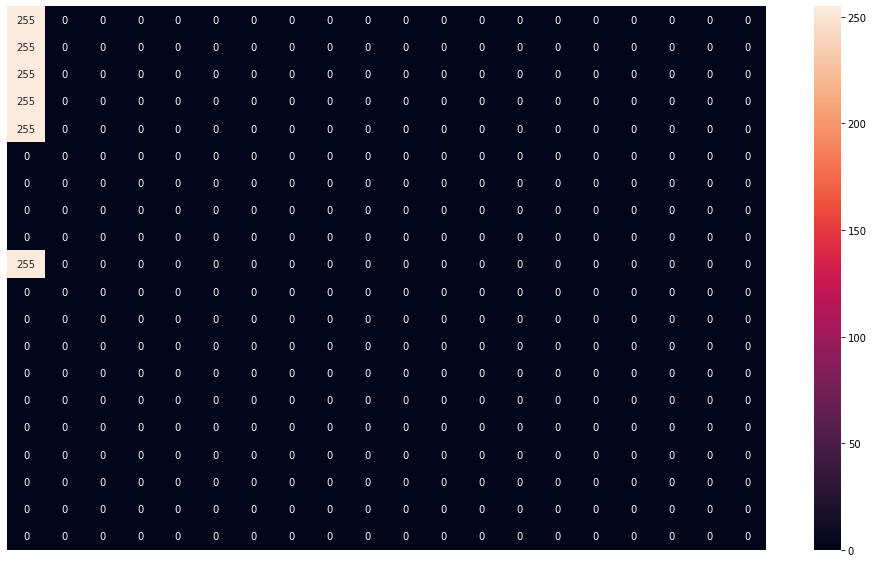

Average_HM


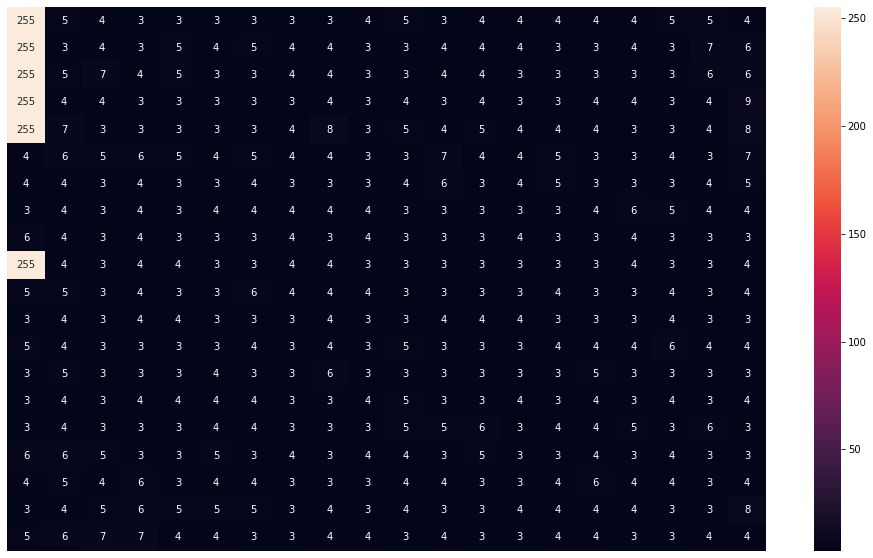

max/median_HM


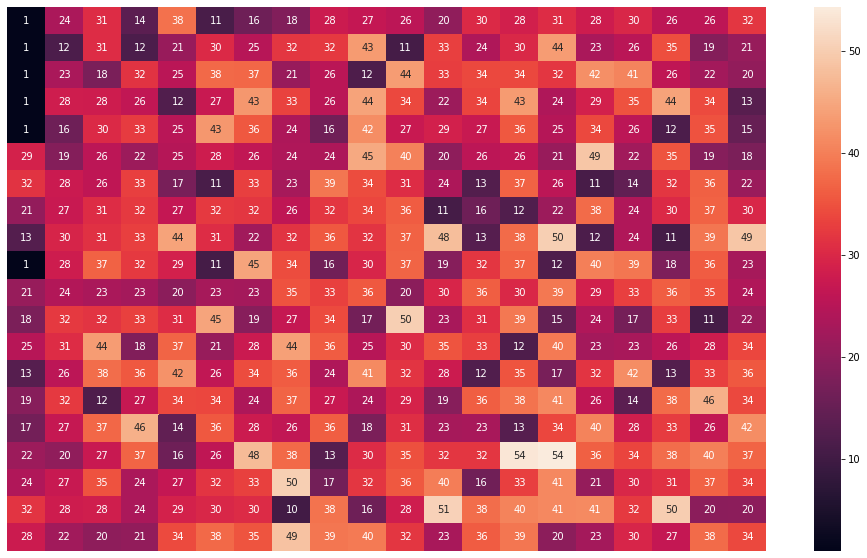

In [408]:
image_info(img2)

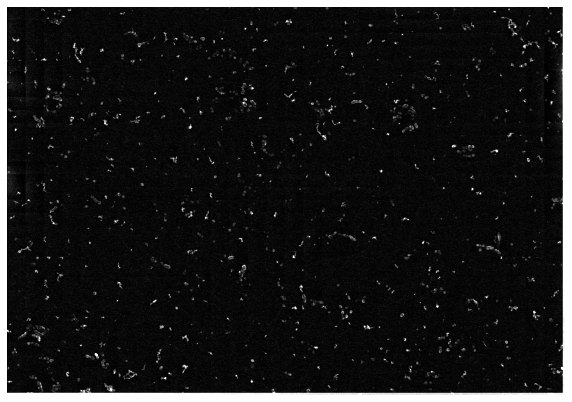

In [284]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=100, cmap='gray')
plt.show()

In [286]:
average_img =np.reshape(average_img,(20,20))

In [277]:
median_img=[]
average_img =[]
img2 = np.copy(img2)
num_rec_x=20
num_rec_y=20
rec_size_x = int(int(height)/num_rec_x)
rec_size_y = int(int(width)/num_rec_y)
for i in range(num_rec_x):
    for j in range(num_rec_y):
        x_min=i*rec_size_x
        y_min=j*rec_size_y
        x_max=x_min+rec_size_x
        y_max=y_min+rec_size_y
        median_img.append(int(np.median(img2[x_min:x_max,y_min:y_max])))
        average_img.append(int(np.average(img2[x_min:x_max,y_min:y_max])))

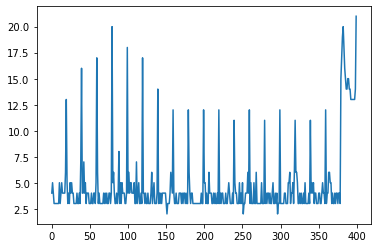

In [285]:
plt.plot(average_img)

In [213]:
median_img=[]
average_img =[]
img2 = np.copy(img2)
num_rec_x=20
num_rec_y=20
rec_size_x = int(int(height)/num_rec_x)
rec_size_y = int(int(width)/num_rec_y)
for i in range(num_rec_x):
    for j in range(num_rec_y):
        x_min=i*rec_size_x
        y_min=j*rec_size_y
        x_max=x_min+rec_size_x
        y_max=y_min+rec_size_y
        median_img.append(int(np.median(img2[x_min:x_max,y_min:y_max])))
        average_img.append(int(np.average(img2[x_min:x_max,y_min:y_max])))
       # img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])

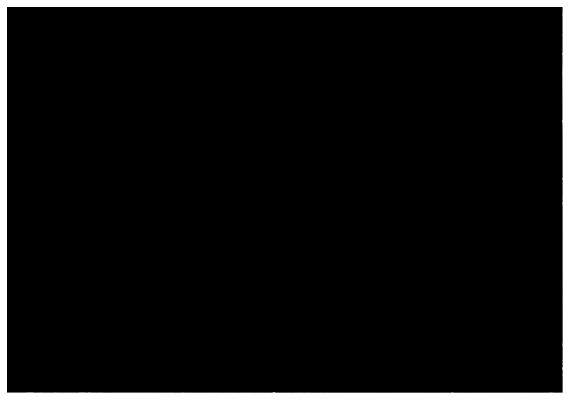

In [227]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=55, cmap='gray')

(0.0, 20.0, 20.0, 0.0)

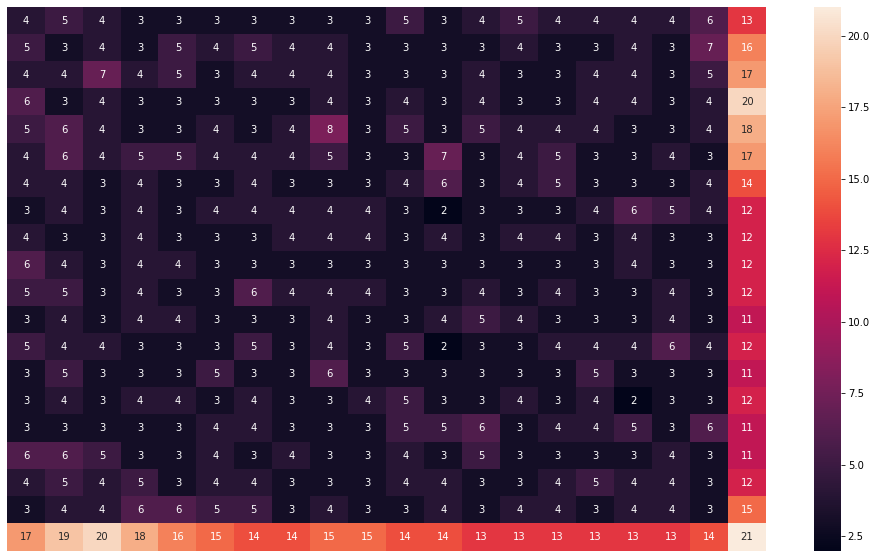

In [287]:
plt.figure(figsize=(17, 10))
sns.heatmap(average_img,annot=True,fmt='.0f')
#plt.tick_params(left=False, bottom=False)
plt.axis(False)

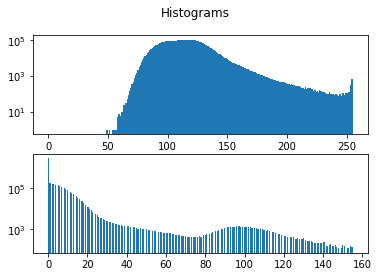

In [57]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))
histograms()

In [50]:
def segmentation(low,denoise,small):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = morphology.remove_small_objects(img_segm, small)
    return img_segm

img_segm = segmentation(20,6,20)

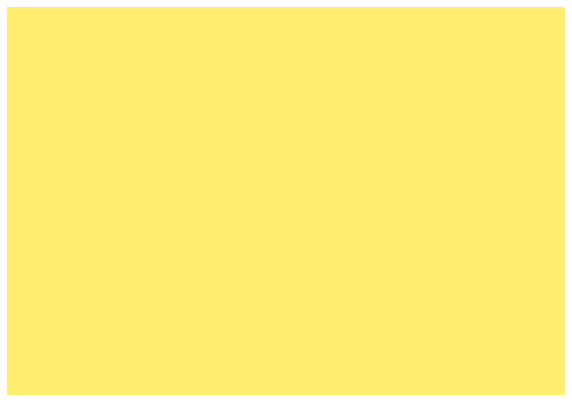

In [38]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm,vmax=155, cmap='Set3_r')

In [11]:
def label_img():
    #img_label = label(img_denoised)
    img2_label = label(img_segm)
   # img_label = clear_border(img_label)
    img2_label = clear_border(img2_label)
    #img_label_overlay = label2rgb(img_label, bg_label=0)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())

    props = regionprops_table(img2_label, img,
                           properties=['area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image'
                                       ])
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]), int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm = data_nm.drop(columns=['image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                                    'img'])

    data_nm[data_nm.columns[0:2]].apply(lambda x:x*pixelsize)
    data_nm[data_nm.columns[0:6]].apply(lambda x:x*pixelsize)
   # data_nm[data_nm.columns[0:6]]*=pixelsize
   # data_nm[data_nm.columns[0:2]]*=pixelsize
    data_nm['circularity'] =data_nm['area']/data_nm['convex_area']
    #data_nm.to_csv('data_nm.csv')
    return img2_label, img2_label_overlay, data_nm
img2_label, img2_label_overlay, data_nm = label_img()

In [12]:
!mkdir '/content/drive/MyDrive/CIOP/images/'RESULTS

mkdir: cannot create directory ‘/content/drive/MyDrive/CIOP/images/RESULTS’: File exists


In [13]:
particles = []
for i in range(1,21):
    img_segm = segmentation(i,6,20)
    img2_label, img2_label_overlay, data_nm = label_img()
    particles.append([i,len(data_nm)])
    #name = sem_dict['ImageName'].split('.')[0]
    #plt.imsave('/content/drive/MyDrive/CIOP/images/RESULTS/'+name+str(i)+'.jpg', img2_label_overlay)

particles = pd.DataFrame(particles, columns=(['segm','number of particles']))

In [14]:
import seaborn as sns

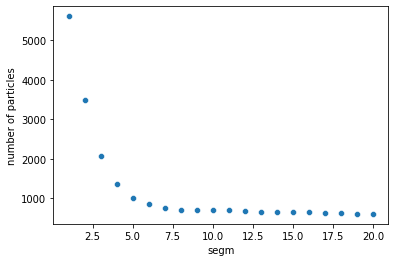

In [15]:
sns.scatterplot(data=particles,x='segm',y='number of particles')
yinterp = np.interp(particles['segm'], particles['segm'], particles['number of particles'])

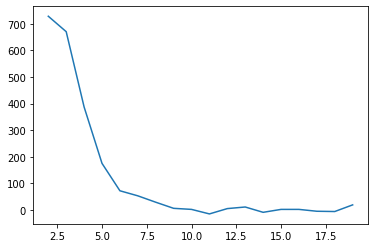

In [16]:
plt.plot(particles['number of particles'].diff().diff())

In [17]:
particles[['segm']].values.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20]])

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
elbow = []
for i in range(2,20-2):
    lm = LinearRegression()
    temp = particles.copy()
    temp['number of particles'] = temp['number of particles']/temp['number of particles'].max()
    left = temp.iloc[:i,:]
    lm.fit(left[['segm']].values.reshape(-1,1),left['number of particles'].values)
    pred = lm.predict(left[['segm']].values.reshape(-1,1))
    mse_left = mean_squared_error(left[['number of particles']].values.reshape(-1,1),pred)
    right = temp.iloc[i:,:]
    lm.fit(right[['segm']].values.reshape(-1,1),right['number of particles'].values)
    pred = lm.predict(right[['segm']].values.reshape(-1,1))
    mse_right = mean_squared_error(right[['number of particles']].values.reshape(-1,1),pred)
    elbow.append([i,mse_left+mse_right])
print(elbow)
elbow = pd.DataFrame(elbow)

[[2, 0.0021140320987601455], [3, 0.001399754802906113], [4, 0.003989722057593591], [5, 0.008272761243588875], [6, 0.012821361882405914], [7, 0.01682911941942516], [8, 0.020192330517318918], [9, 0.02291062312859677], [10, 0.024979202907761337], [11, 0.02647729756925409], [12, 0.02743121379191068], [13, 0.028003646153363197], [14, 0.028332882163797157], [15, 0.02843695328474752], [16, 0.02838068993229242], [17, 0.02821080592707953]]


In [20]:
elbow

,0,1
0,2,0.002114
1,3,0.001400
2,4,0.003990
3,5,0.008273
4,6,0.012821
5,7,0.016829
6,8,0.020192
7,9,0.022911
8,10,0.024979
9,11,0.026477


In [21]:
elbow[elbow[1] == elbow[1].min()]

,0,1
1,3,0.0014


In [22]:
m,b = np.polyfit(particles['segm'], particles['number of particles'], 1)

In [23]:
b

2623.1315789473683

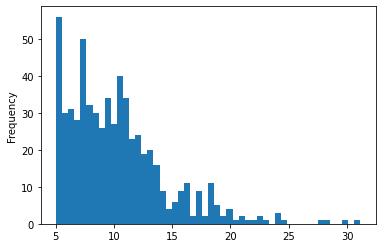

In [24]:
 data_nm['equivalent_diameter'].plot.hist(bins=50)

In [428]:
data = [145, 137, 132, 131, 131, 130, 129, 128, 128, 127, 127, 127, 127, 131, 132, 131, 128, 126, 126, 127, 149, 138, 132, 130, 131, 129, 129, 127, 126, 125, 124, 123, 123, 124, 124, 124, 123, 122, 123, 129, 150, 138, 132, 129, 128, 127, 127, 126, 125, 122, 121, 119, 119, 118, 118, 118, 118, 118, 120, 131, 161, 141, 134, 131, 128, 127, 126, 125, 124, 121, 119, 117, 117, 115, 114, 113, 113, 114, 118, 136, 156, 143, 132, 128, 127, 126, 125, 125, 124, 120, 118, 116, 115, 112, 112, 110, 110, 111, 115, 135, 139, 134, 127, 125, 124, 123, 123, 122, 122, 118, 116, 115, 112, 111, 111, 108, 108, 109, 113, 130, 129, 125, 124, 123, 123, 123, 123, 121, 119, 117, 114, 112, 110, 108, 108, 106, 106, 106, 109, 119, 127, 122, 122, 122, 121, 121, 121, 120, 118, 116, 113, 110, 108, 106, 105, 104, 106, 104, 107, 112, 140, 125, 123, 122, 122, 121, 121, 119, 117, 114, 111, 109, 106, 104, 103, 102, 101, 102, 105, 108, 149, 129, 123, 122, 121, 120, 120, 117, 114, 111, 107, 105, 102, 101, 100, 99, 99, 100, 102, 105, 140, 129, 124, 122, 120, 120, 119, 115, 112, 108, 104, 101, 100, 99, 98, 98, 98, 99, 101, 105, 131, 126, 124, 122, 119, 118, 116, 114, 111, 107, 103, 98, 98, 98, 97, 97, 97, 99, 100, 104, 129, 126, 124, 121, 120, 118, 116, 113, 110, 106, 103, 96, 96, 97, 97, 96, 97, 101, 101, 104, 132, 127, 123, 120, 119, 118, 114, 111, 110, 105, 102, 99, 98, 96, 95, 95, 96, 97, 100, 104, 130, 125, 121, 119, 117, 114, 113, 109, 106, 104, 101, 98, 97, 95, 94, 95, 94, 95, 98, 101, 127, 123, 120, 117, 115, 112, 110, 107, 105, 102, 101, 98, 97, 94, 93, 93, 93, 94, 96, 99, 125, 122, 118, 115, 112, 110, 108, 105, 102, 100, 98, 97, 95, 93, 92, 91, 92, 92, 94, 97, 121, 119, 115, 113, 110, 108, 105, 103, 101, 99, 97, 96, 93, 92, 91, 91, 92, 92, 94, 97, 117, 117, 113, 113, 109, 106, 103, 101, 100, 97, 95, 94, 92, 91, 91, 90, 90, 92, 93, 97, 116, 117, 114, 111, 108, 105, 102, 100, 98, 97, 96, 93, 92, 90, 90, 90, 90, 91, 93, 97]

In [450]:
np.max(data)

161

In [430]:
np.median(data)

113.5

In [439]:
Q1 ,Q2, Q3 = np.percentile(data, [25,50,75])

In [447]:
print(Q1,Q2,Q3)

101.0 113.5 123.0


In [444]:
IQR = Q3-Q1

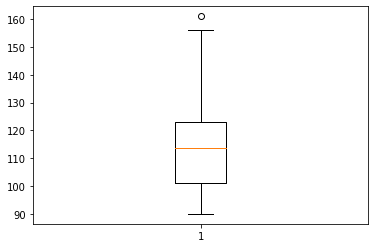

In [454]:
plt.boxplot(data)
plt.show()

In [445]:
Q3+1.5*IQR

156.0

In [446]:
Q1-1.5*IQR

68.0